## Klasyfikacja obrazu za pomocą Sieci Konwolucyjnych


## Wprowadzenie do zadania pierwszego: 'Old Polish Cars'

Spróbujemy stworzyć model, który pozwoli rozpoznać dwa stare polskie samochody. Dostępne jest 2400 oznakowanych zdjęć samochodów do szkolenia i 270 w zestawie testowym, które musimy spróbować opatrzyć etykietą.

In [0]:
# Umieść je na górze każdego notatnika, aby uzyskać automatyczne ponowne ładowanie
%reload_ext autoreload
%autoreload 2

*Tutaj* importujemy niezbędne biblioteki, do czego konkretnie które służą dowiemy się podczas zajęć.

In [0]:
# Ten plik zawiera wszystkie główne biblioteki zewnętrzne, których użyjemy.
from fastai.imports import *

In [0]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

`PATH` jest ścieżką do twoich danych - jeśli użyjesz zalecanych metod konfiguracji z zajęć, nie będziesz musiał tego zmieniać. `sz` to rozmiar, do którego obrazy zostaną przeskalowane w celu zapewnienia szybkiego przebiegu zajęć. Podczas zajęć będziemy rozmawiać o tym parametrze. Zostaw na razie `224` .

In [0]:
PATH = "/content/data/old_polish_cars/old_polish_cars_two_classes_v2a-split/"
sz=224

Ważne jest, aby mieć działający układ GPU NVidia. Schemat programowania używany do pracy z procesorami graficznymi NVidia nosi nazwę CUDA. Dlatego przed kontynuowaniem musisz upewnić się, że następująca linia zwraca wartość `True`. Jeśli masz z tym problemy, sprawdź FAQ i poproś o pomoc [the forums](http://forums.fast.ai).

In [5]:
torch.cuda.is_available()

True

Ponadto NVidia zapewnia specjalne funkcje przyspieszone do głębokiego uczenia się w pakiecie o nazwie CuDNN. Chociaż nie jest to bezwzględnie konieczne, znacznie poprawi wydajność zajęć i jest domyślnie uwzględnione we wszystkich obsługiwanych konfiguracjach fastai. Dlatego jeśli poniższe nie zwróci wartości `True`, warto sprawdzić, dlaczego.

In [6]:
torch.backends.cudnn.enabled

True

## Najpierw obejrzyj zdjęcia samochodów

Nasza biblioteka zakłada, że posiadasz katalogi * train * i * valid *. Zakłada się także, że każdy katalog będzie zawierał podkatalogi dla każdej klasy, która ma zostać rozpaznana (w tym przypadku "maluch", "polonez" itp.).

In [7]:
os.listdir(PATH)

['test2', 'valid', 'train', 'models', 'test2.zip']

In [8]:
os.listdir(f'{PATH}valid')

['maluch', 'polonez']

In [9]:
files = os.listdir(f'{PATH}valid/maluch')[:5]
files

['74_1487452803.65.jpg',
 'fp126p.1.000031.jpg',
 'fp126p.1.000009.jpg',
 '64_1487452793.54.jpg',
 '42_1487452774.7.jpg']

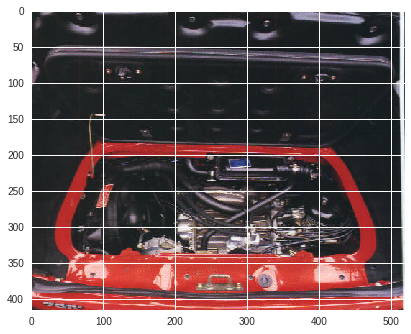

In [10]:
img = plt.imread(f'{PATH}valid/maluch/{files[2]}')
plt.imshow(img);

Oto jak wyglądają dane surowe.

In [11]:
img.shape

(416, 520, 3)

In [12]:
img[:4,:4]

array([[[39, 39, 41],
        [39, 39, 41],
        [39, 39, 41],
        [38, 38, 40]],

       [[38, 39, 41],
        [37, 38, 40],
        [37, 38, 40],
        [37, 38, 40]],

       [[37, 38, 40],
        [37, 38, 40],
        [37, 38, 40],
        [36, 37, 39]],

       [[34, 38, 39],
        [34, 38, 39],
        [34, 38, 39],
        [34, 38, 39]]], dtype=uint8)

## Nasz pierwszy model: szybki start


Użyjemy <b> wstępnie wyszkolonego </b> modelu, czyli modelu stworzonego przez kogoś innego, aby rozwiązać inny problem. Zamiast budować model od zera, aby rozwiązać podobny problem, jako punkt wyjścia wykorzystamy model przeszkolony w ImageNet (1,2 miliona obrazów i 1000 klas). Model ten to Convolutional Neural Network (CNN), rodzaj sieci neuronowej, która buduje najnowocześniejsze modele komputerowej wizji. Podczas tego kursu będziemy się uczyć wszystkiego o CNN.

Będziemy używać modelu <b> resnet34 </ b>. resnet34 to wersja modelu, który wygrał konkurs ImageNet 2015. Tutaj jest więcej informacji na temat [modeli resnet] (https://github.com/KaimingHe/deep-residual-networks). Przyjrzymy się im dogłębnie później, ale na razie skupimy się na ich efektywnym wykorzystaniu.

Oto jak szkolić i oceniać model * starego polskiego samochodu * w 3 liniach kodu i poniżej 20 sekund:

In [0]:
# Odkomentuj poniższe informacje, jeśli chcesz zresetować swoje wstępne aktywacje
# shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

In [14]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 3)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /content/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 80002768.43it/s]


100%|██████████| 5/5 [00:08<00:00,  1.69s/it]


Widget Javascript not detected.  It may not be installed or enabled properly.


epoch      trn_loss   val_loss   accuracy   
    0      0.521872   0.302002   0.875458  
    1      0.405552   0.298686   0.871795  
    2      0.366519   0.270489   0.897436  



[array([0.27049]), 0.8974358976542295]

Jak dobry jest ten model? Kilka lat temu w podobnym zadaniu stan techniki był dokładny w 80%. Ale Kaggle spowodowało ogromny skok do 98,9% celności, a autor popularnej biblioteki dogłębnej nauki zwyciężył w konkursie.

## Analizowanie wyników: oglądanie zdjęć

Oprócz spojrzenia na ogólne wskaźniki warto przyjrzeć się przykładom każdego z nich:

1. Kilka poprawnych etykiet losowo
2. Kilka nieprawidłowych etykiet losowo
3. Najbardziej poprawne etykiety każdej klasy (tj. te z najwyższym prawdopodobieństwem, które są poprawne)
4. Najbardziej niepoprawne etykiety każdej klasy (tj. te z najwyższym prawdopodobieństwem, które są nieprawidłowe)
5. Najbardziej niepewne etykiety (tj. Te z prawdopodobieństwem najbliższym 0,5).

In [15]:
# To jest etykieta dla poprawnych danych
data.val_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1])

In [16]:
# stąd wiemy, że "maluch" to etykieta 0, a "polonez" to etykieta 1.
data.classes

['maluch', 'polonez']

In [17]:
# daje to przewidywanie dla zestawu sprawdzania poprawności. Prognozy są w skali logarytmicznej
log_preds = learn.predict()
log_preds.shape

(273, 2)

In [18]:
log_preds[:10]

array([[-0.00966, -4.645  ],
       [-0.0048 , -5.34077],
       [-0.51914, -0.90395],
       [-0.17644, -1.82168],
       [-1.44716, -0.26819],
       [-0.06495, -2.76641],
       [-0.051  , -3.00131],
       [-0.63071, -0.75975],
       [-2.02766, -0.14115],
       [-0.00231, -6.07261]], dtype=float32)

In [0]:
preds = np.argmax(log_preds, axis=1)  # od logarytmu prawdopodobieństwa do 0 lub 1
probs = np.exp(log_preds[:,1])        # pr(polonez)

In [0]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [0]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [0]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [0]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


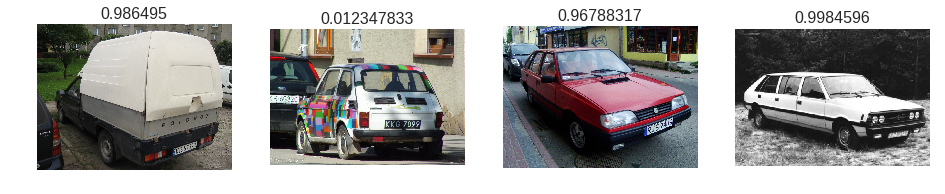

In [24]:
# Kilka poprawnych etykiet losowo
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


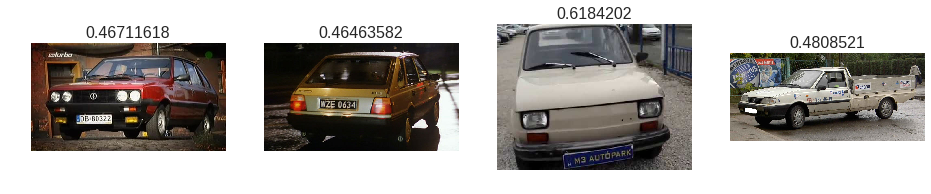

In [25]:
# 2. Kilka niepoprawnych etykiet losowo
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [0]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct maluchs


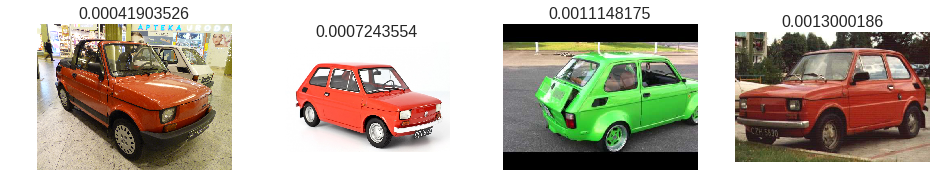

In [27]:
plot_val_with_title(most_by_correct(0, True), "Most correct maluchs")

Most correct polonezes


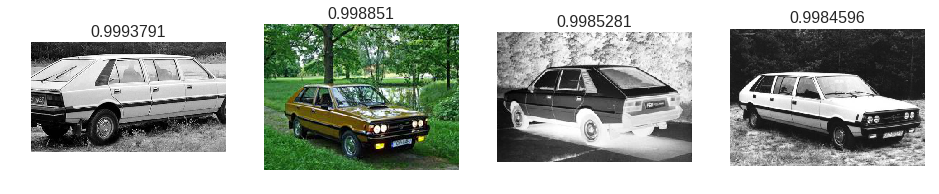

In [28]:
plot_val_with_title(most_by_correct(1, True), "Most correct polonezes")

Most incorrect maluchs


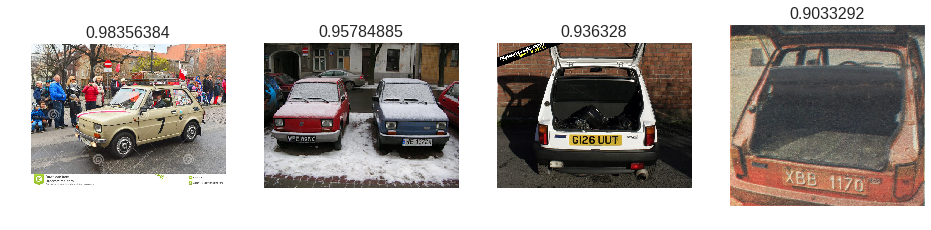

In [29]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect maluchs")

Most incorrect polonezes


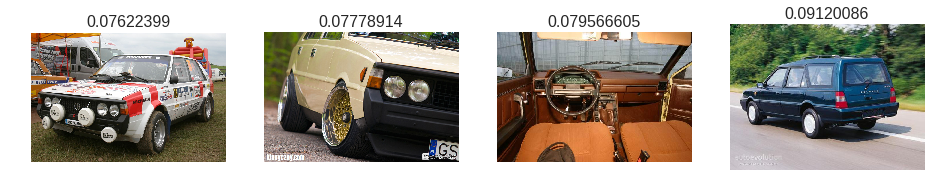

In [30]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect polonezes")

Most uncertain predictions


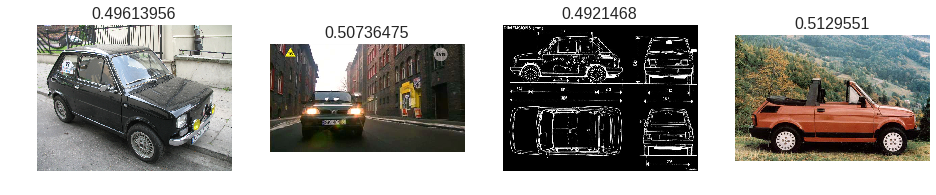

In [31]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

## Wybór wskaźnika uczenia się

Szybkość * nauki * określa, jak szybko lub jak wolno chcesz zaktualizować * wagi * (lub * parametry *). Tempo uczenia się jest jednym z najtrudniejszych parametrów do ustawienia, ponieważ ma znaczący wpływ na wydajność modelu.

Metoda `learn.lr_find ()` pomaga znaleźć optymalną szybkość uczenia się. Wykorzystuje technikę opracowaną w 2015 roku opisaną w publikacji [Cyclical Learning Rates for Training Neural Networks](http://arxiv.org/abs/1506.01186), gdzie po prostu ciągle zwiększamy szybkość uczenia się z bardzo małej wartości, aż strata przestaje maleć. Możemy określić szybkość uczenia się dla różnych partii, aby zobaczyć, jak to wygląda.

Najpierw tworzymy nowego ucznia, ponieważ chcemy wiedzieć, jak ustawić tempo uczenia się dla nowego (niewytrenowanego) modelu.

In [0]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [33]:
lrf=learn.lr_find()

Widget Javascript not detected.  It may not be installed or enabled properly.


 72%|███████▏  | 28/39 [00:00<00:00, 28.46it/s, loss=3.87]


Nasz obiekt `learn` zawiera atrybut` sched`, który zawiera nasz program do planowania szybkości uczenia się i ma kilka wygodnych funkcji kreślenia, w tym:

1.   List item
2.   List item



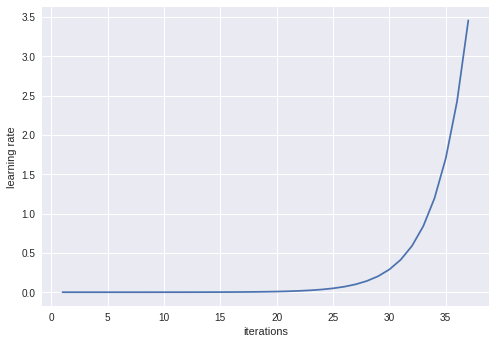

In [34]:
learn.sched.plot_lr()

Widzimy wykres straty w stosunku do wskaźnika uczenia się, aby zobaczyć, gdzie zmniejsza się nasza strata:

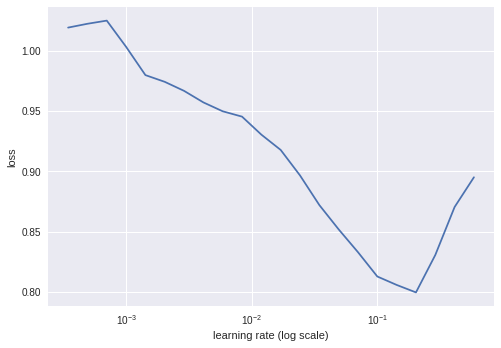

In [35]:
learn.sched.plot()

Utrata wciąż wyraźnie poprawia się w lr = 1e-2 (0.01), więc tego używamy. Zwróć uwagę, że optymalna szybkość uczenia się może się zmieniać podczas treningu modelu, więc możesz chcieć ponownie uruchomić tę funkcję od czasu do czasu.

## Poprawa naszego modelu

### Rozszerzenie danych

Jeśli spróbujesz treningu na więcej epok, zauważysz, że zaczynamy * przetrenowywać *, co oznacza, że nasz model uczy się rozpoznawać konkretne obrazy w zbiorze treningowym, a nie generalizować tak, że uzyskujemy również dobre wyniki na zestawie walidacyjnym. Jednym ze sposobów rozwiązania tego problemu jest efektywne tworzenie większej ilości danych dzięki * rozszerzeniu danych *. Odnosi się to do losowej zmiany obrazów w sposób, który nie powinien wpływać na ich interpretację, takich jak przekręcanie w poziomie, powiększanie i obracanie.

Możemy to zrobić, przekazując `aug_tfms` (* augmentation transforms *) do` tfms_from_model`, z listą funkcji do zastosowania, które losowo zmieniają obraz, jak tylko chcemy. W przypadku zdjęć, które są w dużej mierze pobrane z boku (np. Większość zdjęć samochodów, w przeciwieństwie do zdjęć zrobionych od góry do dołu, takich jak zdjęcia satelitarne), możemy użyć wstępnie zdefiniowanej listy funkcji `transforms_side_on`. Możemy również określić losowe powiększanie obrazów do określonej skali, dodając parametr `max_zoom`.

In [0]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [0]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [0]:
ims = np.stack([get_augs() for i in range(6)])

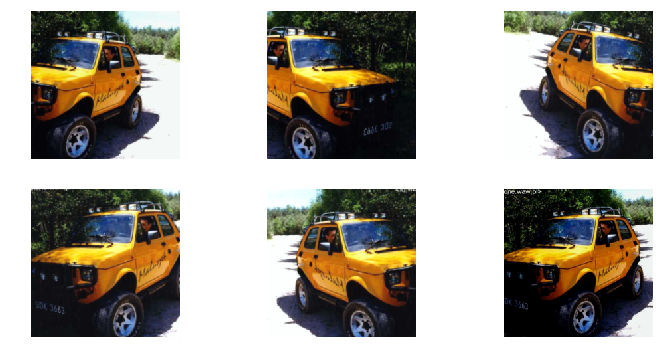

In [39]:
plots(ims, rows=2)

Stwórzmy nowy obiekt "data", który obejmuje to rozszerzenie transformacji.

In [0]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [41]:
learn.fit(1e-2, 1)

Widget Javascript not detected.  It may not be installed or enabled properly.


epoch      trn_loss   val_loss   accuracy   
    0      0.52309    0.330192   0.857143  



[array([0.33019]), 0.8571428573611892]

In [0]:
learn.precompute=False

Domyślnie, gdy tworzymy ucznia, ustawia on wszystkie oprócz ostatniej warstwy na * zamrożone *. Oznacza to, że wciąż aktualizuje wagi tylko w ostatniej warstwie, nazywamy `fit`.

In [43]:
learn.fit(1e-2, 3, cycle_len=1)

Widget Javascript not detected.  It may not be installed or enabled properly.


epoch      trn_loss   val_loss   accuracy   
    0      0.418419   0.322852   0.860806  
    1      0.393061   0.27462    0.908425  
    2      0.384657   0.295376   0.886447  



[array([0.29538]), 0.8864468866652184]

Co to jest parametr `cycle_len`? To, co tutaj zrobiliśmy, to technika zwana * stochastycznym spadkiem gradientu z restartem (SGDR) *, wariantem * wyżarzania szybkości uczenia *, które stopniowo zmniejsza szybkość uczenia się w miarę postępu treningu. Jest to pomocne, ponieważ gdy zbliżamy się do optymalnych wag, chcemy podjąć mniejsze kroki.

Jednakże możemy znaleźć się w części przestrzeni wagi, która nie jest bardzo odporna - to znaczy niewielkie zmiany masy mogą spowodować duże zmiany w stratach. Chcemy zachęcić nasz model do znalezienia części przestrzeni wagi, które są zarówno dokładne, jak i stabilne. Dlatego od czasu do czasu zwiększamy szybkość uczenia się (jest to "restart" w "SGDR"), co zmusi model do przejścia do innej części przestrzeni wagi, jeśli obecny obszar jest "spiczasty". Oto obraz tego, jak to może wyglądać, jeśli zresetujemy współczynniki uczenia się 3 razy (w tym dokumencie nazywają to "cyklicznym harmonogramem LR"):

![SGDR](https://raw.githubusercontent.com/fastai/fastai/master/courses/dl1/images/sgdr.png)
(Z publikacji [Snapshot Ensembles](https://arxiv.org/abs/1704.00109)).

Liczba epok pomiędzy resetowaniem współczynnika uczenia się jest ustalana przez "cykl_liczba", a liczba razy, kiedy to się dzieje, jest określana jako * liczba cykli *, i jest tym, co faktycznie przekazujemy jako drugi parametr do "dopasowania" ( ) `. Oto jak wyglądały nasze rzeczywiste wskaźniki uczenia się:

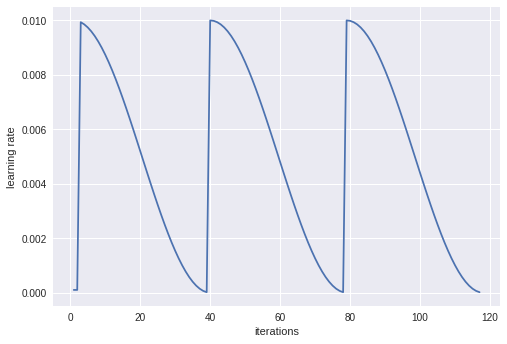

In [44]:
learn.sched.plot_lr()

Nasza strata w zakresie walidacji nie ulega znacznej poprawie, więc prawdopodobnie nie ma potrzeby dalszego szkolenia ostatniej warstwy na własną rękę.

Ponieważ w tym momencie mamy całkiem niezły model, możemy chcieć go zapisać, abyśmy mogli go załadować ponownie później bez szkolenia od zera.

In [0]:
learn.save('224_lastlayer')

In [0]:
learn.load('224_lastlayer')

### Tuning i różnicowanie szybkości uczenia różnicowego

Teraz, gdy mamy już wytrenowaną dobrą warstwę końcową, możemy spróbować dopracować pozostałe warstwy. Aby powiedzieć uczniowi, że chcemy odblokować pozostałe warstwy, wystarczy użyć `Unfreeze ()`.

In [0]:
learn.unfreeze()

Zauważ, że pozostałe warstwy zostały * już * przeszkolone do rozpoznawania zdjęć imagenetowych (podczas gdy nasze końcowe warstwy zostały losowo zainicjowane), więc chcemy uważać, aby nie zniszczyć dokładnie wyregulowanych wag, które już tam są.

Ogólnie mówiąc, wcześniejsze warstwy (jak widzieliśmy) mają więcej funkcji ogólnego przeznaczenia. Dlatego oczekiwalibyśmy, że będą potrzebowali mniejszego dostrajania nowych zestawów danych. Z tego powodu użyjemy różnych poziomów nauki dla różnych warstw: pierwsze kilka warstw będzie na poziomie 1e-4, środkowe warstwy na 1e-3, a nasze warstwy FC opuścimy na 1e-2, tak jak poprzednio. Mówimy o tym jako o * zróżnicowanych wskaźnikach uczenia się *, chociaż nie ma standardowej nazwy dla tej technologii w literaturze, o której nam wiadomo.

In [0]:
lr=np.array([1e-4,1e-3,1e-2])

In [49]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

Widget Javascript not detected.  It may not be installed or enabled properly.


epoch      trn_loss   val_loss   accuracy   
    0      0.359569   0.246196   0.886447  
    1      0.282758   0.177428   0.915751  
    2      0.224875   0.157203   0.92674   
    3      0.201905   0.131458   0.945055  
    4      0.162711   0.121621   0.959707  


    5      0.140113   0.119366   0.952381  
    6      0.136445   0.11781    0.956044  



[array([0.11781]), 0.9560439560439561]

Kolejną sztuczką, której tutaj użyliśmy jest dodanie parametru `cycle_mult`. 

Cykle są mierzone w epokach, więc cycle_len = 1 samo w sobie oznaczałoby ciągłe zmniejszanie szybkości uczenia się w trakcie jednej epoki, a następnie przeskakiwanie z powrotem do góry. Parametr cycle_mult mówi, aby pomnożyć długość cyklu przez coś (w tym przypadku 2), jak tylko ukończysz jeden cykl.

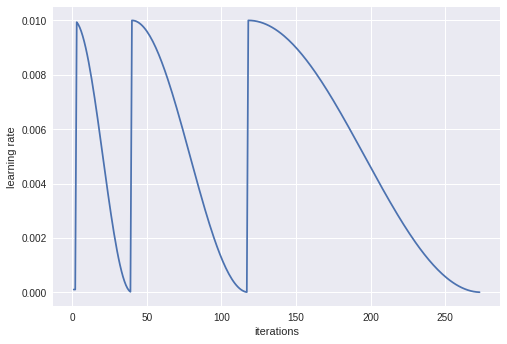

In [50]:
learn.sched.plot_lr()

Zauważ, że to, co przedstawiono powyżej, to wskaźnik uczenia się * ostatnich warstw *. Współczynniki uczenia się wcześniejszych warstw są ustalane na tych samych wielokrotnościach ostatecznych poziomów warstw, zgodnie z pierwotnym żądaniem (tj. Pierwsze warstwy mają 100x mniejsze, a warstwy średnie 10x mniejsze szybkości uczenia się, ponieważ ustawiamy `lr = np.array ([ 1e-4,1e-3,1e-2]) ".

In [0]:
learn.save('224_all')

In [0]:
learn.load('224_all')

Jest jeszcze coś, co możemy zrobić z rozszerzeniem danych: użyj go w * czasie wnioskowania * (znanym również jako * czas testu *). Nic dziwnego, że jest to znane jako * czas testowy * lub po prostu * TTA *.

TTA po prostu tworzy prognozy nie tylko na obrazach w twoim zbiorze sprawdzania poprawności, ale także tworzy prognozy dla pewnej liczby losowo rozszerzonych wersji ich (domyślnie używa oryginalnego obrazu wraz z 4 losowo rozszerzonymi wersjami). Następnie pobiera średnie prognozy z tych obrazów i wykorzystuje je. Aby użyć TTA w zestawie sprawdzania poprawności, możemy skorzystać z metody "TTA ()" ucznia.

In [0]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

100%|██████████| 4/4 [00:34<00:00,  8.67s/it]

In [57]:
accuracy_np(probs, y)

0.9597069597069597

Zwykle widzę o 10-20% spadku błędu w tym zestawie danych podczas korzystania z TTA w tym momencie, co jest niesamowitym wynikiem dla tak szybkiej i prostej techniki!

## Analizowanie wyników

### Macierz błędów (tablica pomyłek)

In [0]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

Popularnym sposobem analizy wyniku modelu klasyfikacyjnego jest użycie [macierzy błędów] (http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). Scikit Learn ma wygodną funkcję, którą możemy wykorzystać do tego celu:


In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

Możemy po prostu wydrukować macierz błędów lub możemy wyświetlić widok graficzny (który jest przydatny głównie dla osób z większą liczbą kategorii).

[[115   7]
 [  4 147]]


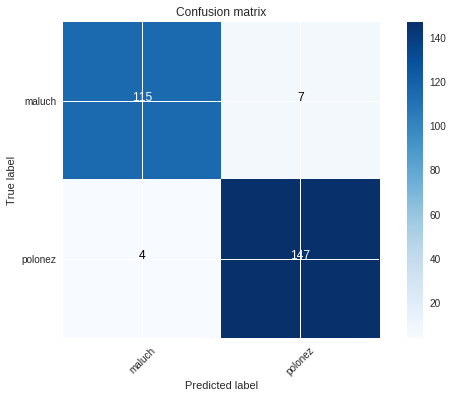

In [60]:
plot_confusion_matrix(cm, data.classes)

### Ponowne spojrzenie na zdjęcia

Most incorrect maluchs


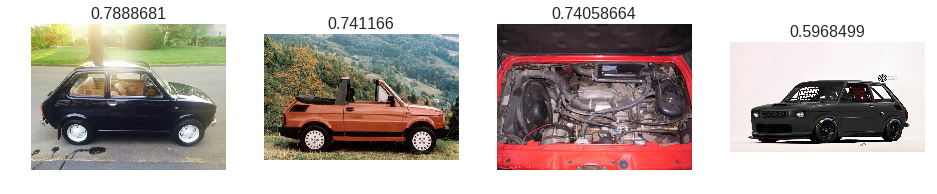

In [61]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect maluchs")

Most incorrect polonezes


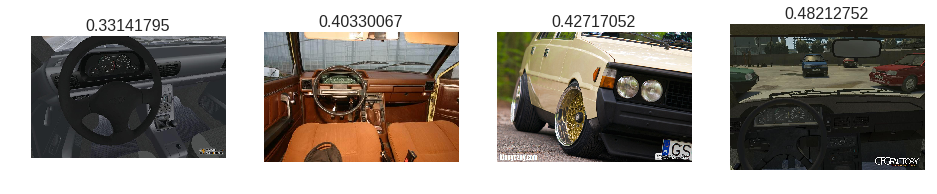

In [62]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect polonezes")

## Recenzja: proste kroki do wyszkolenia klasyfikatora obrazu światowej klasy

1. Włącz data augmentation, oraz precompute=True
1. Użyj `lr_find ()`, aby znaleźć najwyższy wskaźnik uczenia się, w którym strata ciągle się poprawia
1. Wytrenuj ostatnią warstwę z prekomputowanych aktywacji dla 1-2 epok
1. Wytrenuj ostatnią warstwę z rozszerzeniem danych (tj. Precompute = False) dla 2-3 epok z cycle_len = 1
1. Odblokuj wszystkie warstwy
1. Ustaw wcześniejsze warstwy na 3x-10x niższą szybkość uczenia się niż kolejna wyższa warstwa
1. Ponownie użyj `lr_find ()`
1. Trenuj pełną sieć z cycle_mult = 2 aż do dopasowania

## Zrozumienie kodu naszego pierwszego modelu

Spójrzmy na kod linia po linii.

** tfms ** oznacza * transformacje *. `tfms_from_model` zajmuje się zmianą rozmiaru, kadrowaniem obrazu, początkową normalizacją (tworzenie danych za pomocą (średnia, odchylenie standardowe) (0,1)) i więcej.

In [0]:
tfms = tfms_from_model(resnet34, sz)

Potrzebujemy <b> ścieżki </ b> wskazującej na zbiór danych. W tej ścieżce będziemy również przechowywać tymczasowe dane i końcowe wyniki. `ImageClassifierData.from_paths` odczytuje dane z podanej ścieżki i tworzy gotowy zestaw danych do szkolenia.

In [0]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)

`ConvLearner.pretrained` buduje *ucznia* który stanowi wcześniej wytrenowany model. Ostatnia warstwa modelu musi zostać zastąpiona warstwą odpowiednich wymiarów. Ten model został wyszkolony dla 1000 klas, a ostateczna warstwa przewiduje wektor o prawdopodobieństwie 1000. Model dla starych polskich samochodów musi wyprowadzić wektor dwuwymiarowy. Poniższy schemat pokazuje w przykładzie, w jaki sposób zostało to zrobione w jednym z najwcześniej odnoszących sukces CNN. Warstwa "FC8" zostanie tutaj zastąpiona nową warstwą z 2 wyjściami.

<img src="https://image.slidesharecdn.com/practicaldeeplearning-160329181459/95/practical-deep-learning-16-638.jpg" width="500">
[original image](https://image.slidesharecdn.com/practicaldeeplearning-160329181459/95/practical-deep-learning-16-638.jpg)

In [0]:
learn = ConvLearner.pretrained(resnet34, data, precompute=True)

*Parametry* są wyuczane poprzez dopasowanie modelu do danych. * Hyparameters * to kolejny rodzaj parametru, którego nie można bezpośrednio nauczyć się ze zwykłego procesu treningowego. Parametry te wyrażają właściwości "wyższego poziomu" modelu, takie jak jego złożoność lub szybkość uczenia. Dwa przykłady hiperparametrów to * wskaźnik uczenia się * i * liczba epok *.

Podczas iteracyjnego szkolenia sieci neuronowej, * partia (batch) * lub * mini-partia (mini-batch) * jest podzbiorem próbek szkoleniowych używanych w jednej iteracji Stochastycznego Pochodzenia Gradientowego (SGD). Epoka * * to pojedyncze przejście przez cały zestaw treningowy, który składa się z wielu iteracji SGD.

Możemy teraz * dopasować (fit) * model; to znaczy, użyj * gradientowego spadku (gradient descent) *, aby znaleźć najlepsze parametry dla w pełni połączonej warstwy, którą dodaliśmy, która może oddzielać maluchowe obrazy od polonezowych obrazów. Musimy zdać dwa hipertermery: * wskaźnik uczenia się (learning rate)* (ogólnie 1e-2 lub 1e-3 jest dobrym punktem wyjścia, przyjrzymy się temu dalej) i * liczbie epok * (możesz podać wyższy poziom liczbę i po prostu przestań trenować, gdy zauważysz, że już się nie poprawia, a następnie uruchom ponownie z liczbą odnalezionych epok).

In [66]:
learn.fit(1e-2, 1)

Widget Javascript not detected.  It may not be installed or enabled properly.


epoch      trn_loss   val_loss   accuracy   
    0      0.515074   0.295201   0.882784  



[array([0.2952]), 0.8827838830022148]

## Analizowanie wyników: utrata i dokładność

Kiedy uruchamiamy `learn.fit`, drukujemy 3 wartości wydajności (patrz wyżej.) Tutaj 0.03 jest wartością ** straty ** w zbiorze treningowym, 0.0226 jest wartością straty w zestawie walidacji, a 0,9927 jest wartością dokładność weryfikacji. Jaka jest strata? Czym jest dokładność? Dlaczego nie pokazać dokładności?

** Dokładność ** to stosunek prawidłowej prognozy do całkowitej liczby prognoz.

W uczeniu maszynowym funkcja ** straty ** lub koszt reprezentuje cenę zapłaconą za niedokładność prognoz.

Utratę związaną z jednym przykładem w klasyfikacji binarnej daje:
`- (y * log (p) + (1-y) * log (1-p))`
gdzie `y` jest prawdziwą etykietą` x`, a `p` jest prawdopodobieństwem przewidzianym przez nasz model, że etykieta ma wartość 1.

In [0]:
def binary_loss(y, p):
    return np.mean(-(y * np.log(p) + (1-y)*np.log(1-p)))

In [68]:
acts = np.array([1, 0, 0, 1])
preds = np.array([0.9, 0.1, 0.2, 0.8])
binary_loss(acts, preds)

0.164252033486018

Zauważ, że w naszym przykładzie zabawkowym powyżej nasza dokładność wynosi 100%, a nasza strata wynosi 0,16. Porównaj to z utratą 0,03, którą otrzymujemy, podczas przewidywania maluchów i polonezów. 

Ćwiczenie: spróbuj zmodyfikować `preds` tak, aby uzyskać mniejszą stratę dla tego przykładu.

**Przykład:** Oto przykład, jak obliczyć stratę dla jednego przykładu binarnego problemu klasyfikacji. Załóżmy dla obrazu x z etykietą 1, a model daje prognozę 0.9. W tym przypadku strata powinna być mała, ponieważ nasz model przewiduje etykietę $1$ z wysokim prawdopodobieństwem.

`loss = -log (0.9) = 0.10`

Załóżmy teraz, że x ma etykietę 0, ale nasz model przewiduje 0.9. W tym przypadku nasza strata powinna być znacznie większa.

strata = -log (1-0,9) = 2,30


- Ćwiczenie: spójrz na inne przypadki i przekonaj się, że to ma sens.
- Ćwiczenie: w jaki sposób przepisałbyś `binary_loss` używając` if` zamiast `*` i `+`?

Dlaczego po prostu nie zwiększyć dokładności? Utrata klasyfikacji binarnej jest łatwiejszą funkcją do optymalizacji.
